In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb

In [8]:
df_train = pd.read_csv("../data/train-metadata.csv")
df_test = pd.read_csv("../data/test-metadata.csv")

def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
    
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence'
] + new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

/tmp/ipykernel_820432/4175578027.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/train-metadata.csv")


In [9]:
gkf = GroupKFold(n_splits=5) # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])):
    df_train.loc[val_idx, "fold"] = idx

In [10]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

import random

__n_estimators         = random.choice([1400,1500,2000])                  # 800,900,1000,1100,1200,1300,
__learning_rate        = random.choice([0.003,0.002,0.001])               # 0.005,0.004,
__lambda_l1            = random.choice([0.14,0.21,0.27,0.37])
__lambda_l2            = random.choice([0.7,1.0,1.47,1.77,2.77])
__pos_bagging_fraction = random.choice([0.74, 0.75, 0.77, 0.777])
__neg_bagging_fraction = random.choice([0.04,0.05,0.07,0.077])
__feature_fraction     = random.choice([0.5,0.54,0.57,0.7,0.77,0.777])
__num_leaves           = random.choice([16, 20, 24, 30,33,37])            # 24,30,31,32,33,37
__min_data_in_leaf     = random.choice([16, 20, 24, 40,50,57])            # 40,45,50,55,57

lgb_params = {
    'objective': 'binary',
    "random_state": 42,
    "n_estimators":__n_estimators,
    'learning_rate':__learning_rate,
    'num_leaves':__num_leaves,
    'min_data_in_leaf':__min_data_in_leaf,
    'bagging_freq': 1,
    'pos_bagging_fraction':__pos_bagging_fraction,
    'neg_bagging_fraction':__neg_bagging_fraction,
    'feature_fraction':__feature_fraction,
    'lambda_l1':__lambda_l1,
    'lambda_l2':__lambda_l2,
    "verbosity": -1,
    # "extra_trees": True
}

print('\n',
      __n_estimators,
      __learning_rate,
      __lambda_l1,
      __lambda_l2,
      __pos_bagging_fraction,
      __neg_bagging_fraction,
      __feature_fraction,
      __num_leaves,
      __min_data_in_leaf,
'\n')

scores = []
models = []
for fold in range(5):
    _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
    _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
    model = lgb.LGBMRegressor(
        **lgb_params
    )
    model.fit(_df_train[train_cols], _df_train["target"])
    preds = model.predict(_df_valid[train_cols])
    score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
    print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    scores.append(score)
    models.append(model)


 2000 0.002 0.14 1.77 0.777 0.05 0.77 33 24 



fold: 0 - Partial AUC Score: 0.16440
fold: 1 - Partial AUC Score: 0.15584
fold: 2 - Partial AUC Score: 0.14991
fold: 3 - Partial AUC Score: 0.15655
fold: 4 - Partial AUC Score: 0.15682


In [11]:
np.mean(scores)

0.15670428797438798

In [12]:
importances = np.mean([model.feature_importances_ for model in models], 0)
df_imp = pd.DataFrame({"feature": model.feature_name_, "importance": importances}).sort_values("importance").reset_index(drop=True)

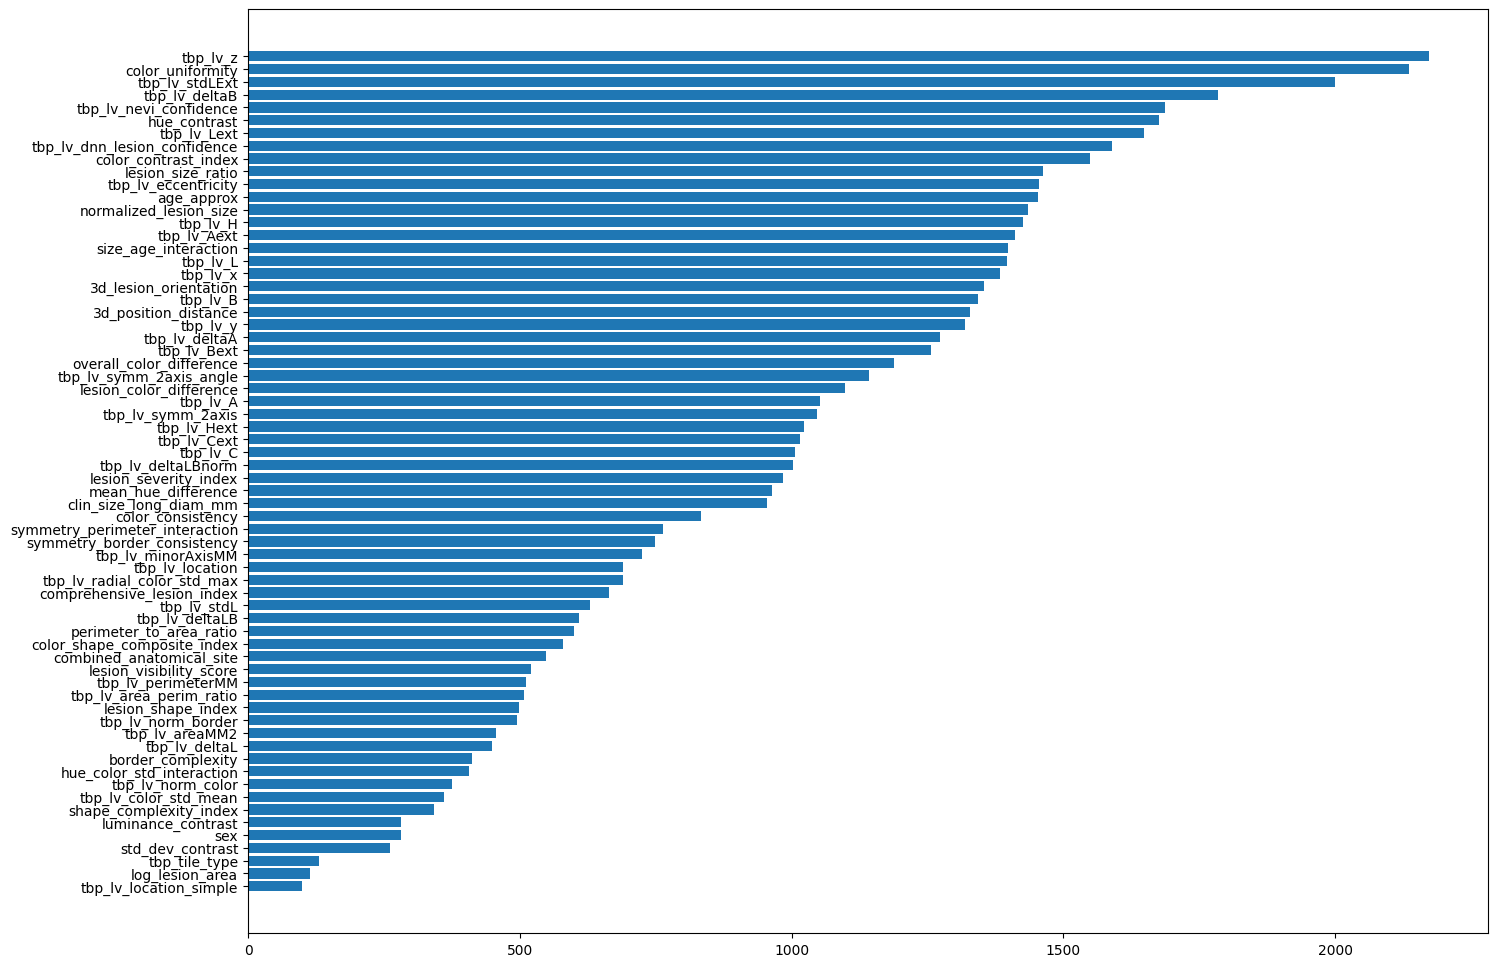

In [13]:
plt.figure(figsize=(16, 12))
plt.barh(df_imp["feature"], df_imp["importance"])
plt.show()

In [14]:
df_imp[df_imp["feature"].isin(new_num_cols + new_cat_cols)].sort_values("importance", ascending=False)

,feature,importance
64,color_uniformity,2135.4
60,hue_contrast,1676.0
57,color_contrast_index,1549.0
56,lesion_size_ratio,1461.8
53,normalized_lesion_size,1435.0
50,size_age_interaction,1398.0
47,3d_lesion_orientation,1353.8
45,3d_position_distance,1329.2
41,overall_color_difference,1188.8
39,lesion_color_difference,1098.0


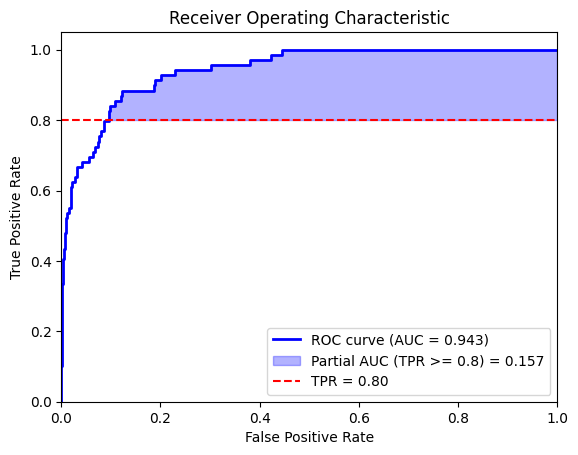

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values) - 1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1 - min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # Change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

tpr_threshold = 0.8

# Generate example data
y_true = _df_valid[["target"]].values
y_scores = preds

# Convert to DataFrame as expected by comp_score function
solution = pd.DataFrame(y_true, columns=['label'])
submission = pd.DataFrame(y_scores, columns=['score'])

# Calculate the partial AUC using the competition's scoring function
pAUC_comp = comp_score(solution, submission, row_id_column_name="", min_tpr=0.80)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)

# Shade the area where TPR >= 80%
start_idx = np.where(tpr >= tpr_threshold)[0][0]
fpr_shade = np.concatenate(([fpr[start_idx]], fpr[start_idx:], [1]))
tpr_shade = np.concatenate(([tpr_threshold], tpr[start_idx:], [tpr_threshold]))
plt.fill_between(fpr_shade, tpr_shade, y2=0.8, alpha=0.3, color='blue', label='Partial AUC (TPR >= 0.8) = %0.3f' % pAUC_comp)

# Add dashed line for TPR threshold
plt.axhline(y=tpr_threshold, color='red', linestyle='--', label='TPR = 0.80')

# Add labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Test

In [18]:
X_cat = category_encoder.fit_transform(df_test[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_test[cat_col] = X_cat[:, c]

In [19]:
preds = np.mean([model.predict(df_test[train_cols]) for model in models], 0)

In [22]:
df_sub = pd.read_csv("../sample_submission.csv")
df_sub["target"] = preds
df_sub

,isic_id,target
0,ISIC_0015657,0.000964
1,ISIC_0015729,0.000803
2,ISIC_0015740,0.002128


In [3]:
import numpy as np
import pandas as pd
import pandas.api.types
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

import lightgbm as lgb

df_train = pd.read_csv("../data/train-metadata.csv")
df_test = pd.read_csv("../data/test-metadata.csv")

def feature_engineering(df):
    # New features to try...
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    df["lesion_shape_index"] = df["tbp_lv_areaMM2"] / (df["tbp_lv_perimeterMM"] ** 2)
    df["hue_contrast"] = (df["tbp_lv_H"] - df["tbp_lv_Hext"]).abs()
    df["luminance_contrast"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs()
    df["lesion_color_difference"] = np.sqrt(df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2)
    df["border_complexity"] = df["tbp_lv_norm_border"] + df["tbp_lv_symm_2axis"]
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df["3d_position_distance"] = np.sqrt(df["tbp_lv_x"] ** 2 + df["tbp_lv_y"] ** 2 + df["tbp_lv_z"] ** 2) 
    df["perimeter_to_area_ratio"] = df["tbp_lv_perimeterMM"] / df["tbp_lv_areaMM2"]
    df["lesion_visibility_score"] = df["tbp_lv_deltaLBnorm"] + df["tbp_lv_norm_color"]
    df["combined_anatomical_site"] = df["anatom_site_general"] + "_" + df["tbp_lv_location"]
    df["symmetry_border_consistency"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_norm_border"]
    df["color_consistency"] = df["tbp_lv_stdL"] / df["tbp_lv_Lext"]
    
    df["size_age_interaction"] = df["clin_size_long_diam_mm"] * df["age_approx"]
    df["hue_color_std_interaction"] = df["tbp_lv_H"] * df["tbp_lv_color_std_mean"]
    df["lesion_severity_index"] = (df["tbp_lv_norm_border"] + df["tbp_lv_norm_color"] + df["tbp_lv_eccentricity"]) / 3
    df["shape_complexity_index"] = df["border_complexity"] + df["lesion_shape_index"]
    df["color_contrast_index"] = df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"] + df["tbp_lv_deltaLBnorm"]
    df["log_lesion_area"] = np.log(df["tbp_lv_areaMM2"] + 1)
    df["normalized_lesion_size"] = df["clin_size_long_diam_mm"] / df["age_approx"]
    df["mean_hue_difference"] = (df["tbp_lv_H"] + df["tbp_lv_Hext"]) / 2
    df["std_dev_contrast"] = np.sqrt((df["tbp_lv_deltaA"] ** 2 + df["tbp_lv_deltaB"] ** 2 + df["tbp_lv_deltaL"] ** 2) / 3)
    df["color_shape_composite_index"] = (df["tbp_lv_color_std_mean"] + df["tbp_lv_area_perim_ratio"] + df["tbp_lv_symm_2axis"]) / 3
    df["3d_lesion_orientation"] = np.arctan2(df_train["tbp_lv_y"], df_train["tbp_lv_x"])
    df["overall_color_difference"] = (df["tbp_lv_deltaA"] + df["tbp_lv_deltaB"] + df["tbp_lv_deltaL"]) / 3
    df["symmetry_perimeter_interaction"] = df["tbp_lv_symm_2axis"] * df["tbp_lv_perimeterMM"]
    df["comprehensive_lesion_index"] = (df["tbp_lv_area_perim_ratio"] + df["tbp_lv_eccentricity"] + df["tbp_lv_norm_color"] + df["tbp_lv_symm_2axis"]) / 4

    # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
    df["color_variance_ratio"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_stdLExt"]
    df["border_color_interaction"] = df["tbp_lv_norm_border"] * df["tbp_lv_norm_color"]
    df["size_color_contrast_ratio"] = df["clin_size_long_diam_mm"] / df["tbp_lv_deltaLBnorm"]
    df["age_normalized_nevi_confidence"] = df["tbp_lv_nevi_confidence"] / df["age_approx"]
    df["color_asymmetry_index"] = df["tbp_lv_radial_color_std_max"] * df["tbp_lv_symm_2axis"]
    df["3d_volume_approximation"] = df["tbp_lv_areaMM2"] * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    df["color_range"] = (df["tbp_lv_L"] - df["tbp_lv_Lext"]).abs() + (df["tbp_lv_A"] - df["tbp_lv_Aext"]).abs() + (df["tbp_lv_B"] - df["tbp_lv_Bext"]).abs()
    df["shape_color_consistency"] = df["tbp_lv_eccentricity"] * df["tbp_lv_color_std_mean"]
    df["border_length_ratio"] = df["tbp_lv_perimeterMM"] / (2 * np.pi * np.sqrt(df["tbp_lv_areaMM2"] / np.pi))
    df["age_size_symmetry_index"] = df["age_approx"] * df["clin_size_long_diam_mm"] * df["tbp_lv_symm_2axis"]
    # Until here.
    
    new_num_cols = [
        "lesion_size_ratio", "lesion_shape_index", "hue_contrast",
        "luminance_contrast", "lesion_color_difference", "border_complexity",
        "color_uniformity", "3d_position_distance", "perimeter_to_area_ratio",
        "lesion_visibility_score", "symmetry_border_consistency", "color_consistency",

        "size_age_interaction", "hue_color_std_interaction", "lesion_severity_index", 
        "shape_complexity_index", "color_contrast_index", "log_lesion_area",
        "normalized_lesion_size", "mean_hue_difference", "std_dev_contrast",
        "color_shape_composite_index", "3d_lesion_orientation", "overall_color_difference",
        "symmetry_perimeter_interaction", "comprehensive_lesion_index",
        
        "color_variance_ratio", "border_color_interaction", "size_color_contrast_ratio",
        "age_normalized_nevi_confidence", "color_asymmetry_index", "3d_volume_approximation",
        "color_range", "shape_color_consistency", "border_length_ratio", "age_size_symmetry_index",
    ]
    new_cat_cols = ["combined_anatomical_site"]
    return df, new_num_cols, new_cat_cols

num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 
    'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 
    'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
    'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z',
]
df_train[num_cols] = df_train[num_cols].fillna(df_train[num_cols].median())
df_train, new_num_cols, new_cat_cols = feature_engineering(df_train.copy())
df_test, _, _ = feature_engineering(df_test.copy())
num_cols += new_num_cols
# anatom_site_general
cat_cols = ["sex", "tbp_tile_type", "tbp_lv_location", "tbp_lv_location_simple"] + new_cat_cols
train_cols = num_cols + cat_cols

category_encoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)

X_cat = category_encoder.fit_transform(df_train[cat_cols])
for c, cat_col in enumerate(cat_cols):
    df_train[cat_col] = X_cat[:, c]

gkf = StratifiedGroupKFold(n_splits=5)  # , shuffle=True, random_state=42

df_train["fold"] = -1
for idx, (train_idx, val_idx) in enumerate(
    gkf.split(df_train, df_train["target"], groups=df_train["patient_id"])
):
    df_train.loc[val_idx, "fold"] = idx


# def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
#     v_gt = abs(np.asarray(solution.values)-1)
#     v_pred = np.array([1.0 - x for x in submission.values])
#     max_fpr = abs(1-min_tpr)
#     partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
#     # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
#     # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
#     partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
#     return partial_auc


# lgb_params =  {
#     "objective": "binary",
#     "verbosity": -1,
#     "boosting_type": "gbdt",
#     "n_estimators": 200,
#     'learning_rate': 0.05,    
#     'lambda_l1': 0.0004681884533249742, 
#     'lambda_l2': 8.765240856362274, 
#     'num_leaves': 136, 
#     'feature_fraction': 0.5392005444882538, 
#     'bagging_fraction': 0.9577412548866563, 
#     'bagging_freq': 6,
#     'min_child_samples': 60,
#     "device": "gpu"
# }

# scores = []
# models = []
# targets = []
# preds_fold = []
# for fold in range(5):
#     _df_train = df_train[df_train["fold"] != fold].reset_index(drop=True)
#     _df_valid = df_train[df_train["fold"] == fold].reset_index(drop=True)
#     model = lgb.LGBMRegressor(
#         **lgb_params
#     )
#     model.fit(_df_train[train_cols], _df_train["target"])
#     preds = model.predict(_df_valid[train_cols])
#     score = comp_score(_df_valid[["target"]], pd.DataFrame(preds, columns=["prediction"]), "")
#     print(f"fold: {fold} - Partial AUC Score: {score:.5f}")
    
#     targets.extend(_df_valid["target"])
#     preds_fold.extend(preds)

#     scores.append(score)
#     models.append(model)

# score = np.mean(scores)
# print(f"LGBM Score: {score:.5f}")

# ## Plot pAUC
# tpr_threshold = 0.8

# fpr, tpr, thresholds = roc_curve(targets, preds_fold)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (AUC = %0.3f)" % roc_auc)

# start_idx = np.where(tpr >= tpr_threshold)[0][0]
# fpr_shade = np.concatenate(([fpr[start_idx]], fpr[start_idx:], [1]))
# tpr_shade = np.concatenate(([tpr_threshold], tpr[start_idx:], [tpr_threshold]))
# plt.fill_between(
#     fpr_shade,
#     tpr_shade,
#     y2=0.8,
#     alpha=0.3,
#     color="blue",
#     label="Partial AUC (TPR >= 0.8) = %0.4f" % score,
# )
# plt.axhline(y=tpr_threshold, color="red", linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Receiver Operating Characteristic")
# plt.legend(loc="lower right")
# plt.show()

/tmp/ipykernel_990925/535283786.py:11: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("../data/train-metadata.csv")


In [4]:
df_train.to_csv("../data/stratified_5_fold_train_metadata.csv", index=False)